In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

In [38]:
class SuperResolutionMNIST(Dataset):
    def __init__(self, root, train=True, transform_low=None, transform_high=None):
        self.high_res_data = datasets.MNIST(root=root, train=train, download=True, transform=transform_high)
        self.low_res_data = datasets.MNIST(root=root, train=train, download=True, transform=transform_low)

    def __len__(self):
        return len(self.high_res_data)

    def __getitem__(self, idx):
        high_res_image, label = self.high_res_data[idx]
        low_res_image, _ = self.low_res_data[idx]
        return low_res_image, high_res_image  # low-res input, high-res target

# transforms
transform_high = transforms.ToTensor()  # Original 28x28 resolution
transform_low = transforms.Compose([
    transforms.Resize(14),  # Downscale to 14x14
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

# Create the dataset
train_data = SuperResolutionMNIST(root='./data', train=True, transform_low=transform_low, transform_high=transform_high)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

valid_data = SuperResolutionMNIST(root='./data', train=False, transform_low=transform_low, transform_high=transform_high)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)


In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder for 14x14 input -- downsampling 
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 7x7 -> 4x4
            nn.ReLU()
        )

        # Decoder for upsampling to 28x28
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1), # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1), # 16x16 -> 28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [47]:
# Instantiate and train the model
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [42]:
import matplotlib.pyplot as plt
from tqdm import tqdm


num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for low_res_img, high_res_img in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        # Forward pass
        output = model(low_res_img)
        output = transforms.Resize(28)(output)
        loss = criterion(output, high_res_img)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #  training loss
        train_loss += loss.item()

    # average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    val_loss = 0
    with torch.no_grad():
        for low_res_img, high_res_img in tqdm(valid_loader, desc="Validation"):
            output = model(low_res_img)
            output = transforms.Resize(28)(output)  # output different than 28 x 28
            loss = criterion(output, high_res_img)
            val_loss += loss.item()

    # average validation loss
    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

Validation: 100%|██████████| 157/157 [00:06<00:00, 25.73it/s]


Epoch [1/5], Training Loss: 0.0099, Validation Loss: 0.0092


Validation: 100%|██████████| 157/157 [00:06<00:00, 22.63it/s]


Epoch [2/5], Training Loss: 0.0093, Validation Loss: 0.0087


Validation: 100%|██████████| 157/157 [00:06<00:00, 26.04it/s]


Epoch [3/5], Training Loss: 0.0089, Validation Loss: 0.0084


Validation: 100%|██████████| 157/157 [00:06<00:00, 24.08it/s]


Epoch [4/5], Training Loss: 0.0085, Validation Loss: 0.0081


Validation: 100%|██████████| 157/157 [00:06<00:00, 22.60it/s]

Epoch [5/5], Training Loss: 0.0082, Validation Loss: 0.0078


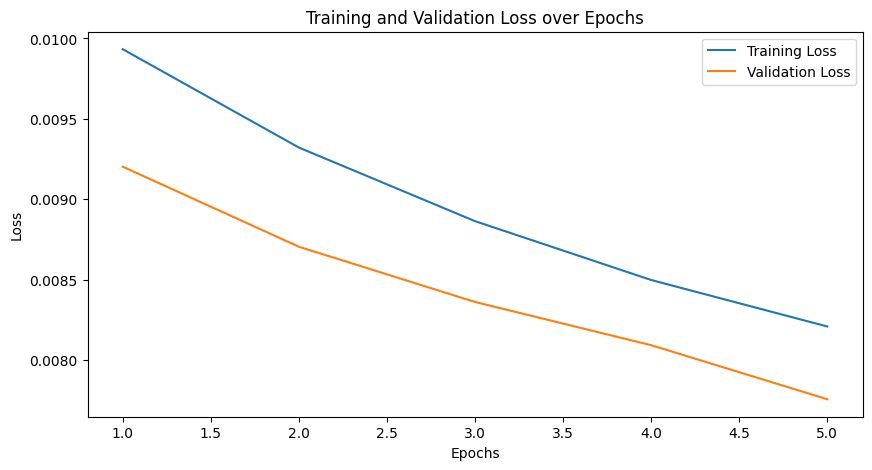

In [43]:
# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [44]:
test_data_visual = SuperResolutionMNIST(root='./data', train=False, transform_low=transform_low, transform_high=transform_high)
visual_loader = DataLoader(test_data_visual, batch_size=1, shuffle=True)

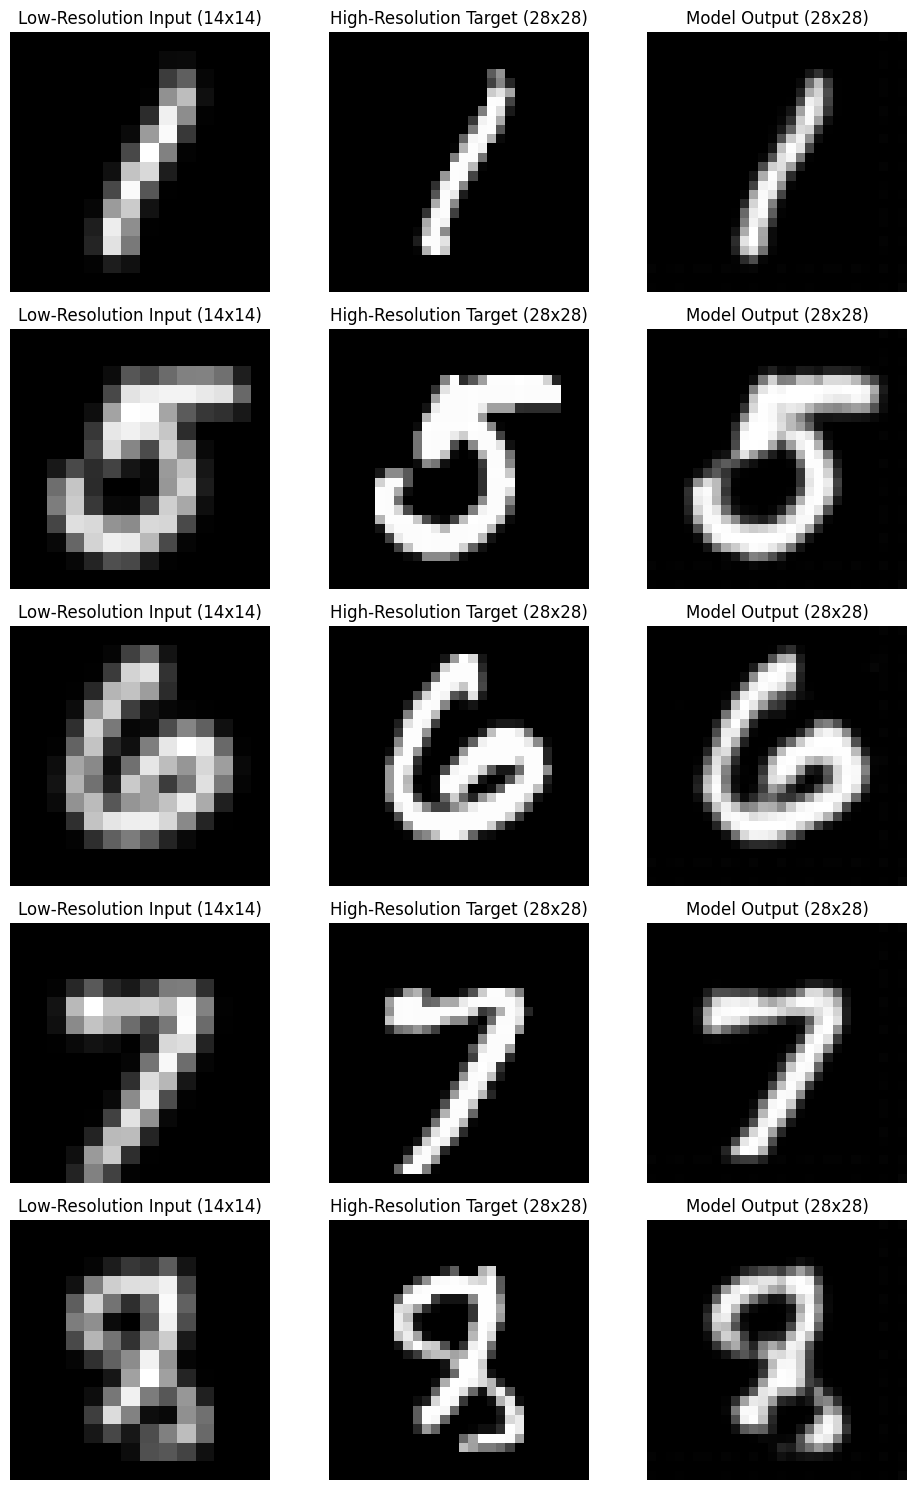

In [45]:
import matplotlib.pyplot as plt

model.eval()

# Number of samples to visualize
num_samples = 5
fig, axarr = plt.subplots(num_samples, 3, figsize=(10, 3 * num_samples))

with torch.no_grad():
    for i, (low_res_img, high_res_img) in enumerate(visual_loader):
        if i == num_samples:
            break

        output = model(low_res_img)
        output = transforms.Resize(28)(output)

        # Low-resolution input
        axarr[i, 0].imshow(low_res_img.squeeze().cpu().numpy(), cmap='gray')
        axarr[i, 0].set_title("Low-Resolution Input (14x14)")
        axarr[i, 0].axis('off')

        # High-resolution target
        axarr[i, 1].imshow(high_res_img.squeeze().cpu().numpy(), cmap='gray')
        axarr[i, 1].set_title("High-Resolution Target (28x28)")
        axarr[i, 1].axis('off')

        # Model output
        axarr[i, 2].imshow(output.squeeze().detach().cpu().numpy(), cmap='gray')
        axarr[i, 2].set_title("Model Output (28x28)")
        axarr[i, 2].axis('off')

plt.tight_layout()
plt.show()